<a href="https://colab.research.google.com/github/Abishethvarman/FakeNewsDetection/blob/main/V1_3_Sentiment_Analysis_VADER_FakeNews_Full_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment Analysis on VADER https://www.youtube.com/watch?v=QpzMWQvxXWk

In [1]:
!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import gensim
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

import plotly.express as px
from tqdm.notebook import tqdm

plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [4]:
%cd /mydrive/dataset/

/content/gdrive/My Drive/dataset


In [5]:
df_reliable = pd.read_csv("Reliable.csv")
df_fake = pd.read_csv("Fake.csv")

In [6]:
df_reliable['isfake'] = 0
df_fake['isfake'] = 1

In [14]:
target_samples = 10000
reliable_news = df_reliable[df_reliable['isfake'] == 0].sample(n=target_samples, random_state=42)
fake_news = df_fake[df_fake['isfake'] == 1].sample(n=target_samples, random_state=42)

df_adjusted = pd.concat([reliable_news, fake_news], ignore_index=True)
df_adjusted = df_adjusted.sample(frac=1, random_state=42)

In [17]:
df_adjusted.shape

(20000, 5)

In [18]:
df_adjusted

title  \
10650   Vicente Fox Brilliantly Trolls Trump’s Disast...   
2041   U.S. and EU warn China on need to respect Sout...   
8668   UK Supreme Court hears attempt to change North...   
1114   Guatemalan president survives congressional vo...   
13902  Mueller Team Uniform? ‘Democratic Donkey Jerse...   
...                                                  ...   
11284   White House Defends Boehner’s ‘Lucifer’ Comme...   
11964  HILARIOUS: TRUMP EXPOSES STUPIDITY OF NBC PUPP...   
5390   Mueller seeking testimony from PR executives w...   
860    Supreme Court dismisses Hawaii's challenge to ...   
15795  WOMAN Who Wants To Become DNC Chair: “My job i...   

                                                    text       subject  \
10650  Former Mexican President Vicente Fox has never...          News   
2041   WASHINGTON (Reuters) - The United States and t...  politicsNews   
8668   LONDON (Reuters) - An attempt to change the la...     worldnews   
1114   GUATEMALA CITY (Reuters) - Guatemala s Congres...     worldnews   
13902  Deputy Attorney General Rod Rosenstein appeare...   Middle-east   
...                                                  ...           ...   
11284  Ever since former House Speaker John Boehner a...          News   
11964  Trump made sure everyone got a chance to see h...      politics   
5390   WASHINGTON (Reuters) - Special Counsel Robert ...  politicsNews   
860    WASHINGTON (Reuters) - The U.S. Supreme Court ...  politicsNews   
15795  The Democratic Party held a forum for race obs...      politics   

                      date  isfake  
10650         May 17, 2017       1  
2041    February 18, 2016        0  
8668     October 24, 2017        0  
1114   September 12, 2017        0  
13902    December 13, 2017       1  
...                    ...     ...  
11284       April 29, 2016       1  
11964         Aug 19, 2015       1  
5390      August 25, 2017        0  
860      October 24, 2017        0  
15795         Jan 24, 2017       1  

[20000 rows x 5 columns]

In [19]:
print(df_reliable['subject'].unique())
print(df_fake['subject'].unique())

['politicsNews' 'worldnews']
['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


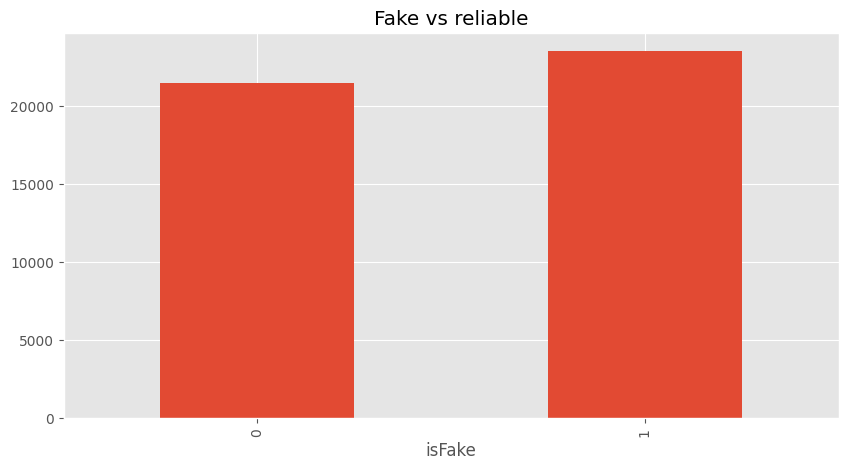

In [20]:
ax = df['isfake'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Fake vs reliable',
          figsize=(10, 5))
ax.set_xlabel('isFake')
plt.show()

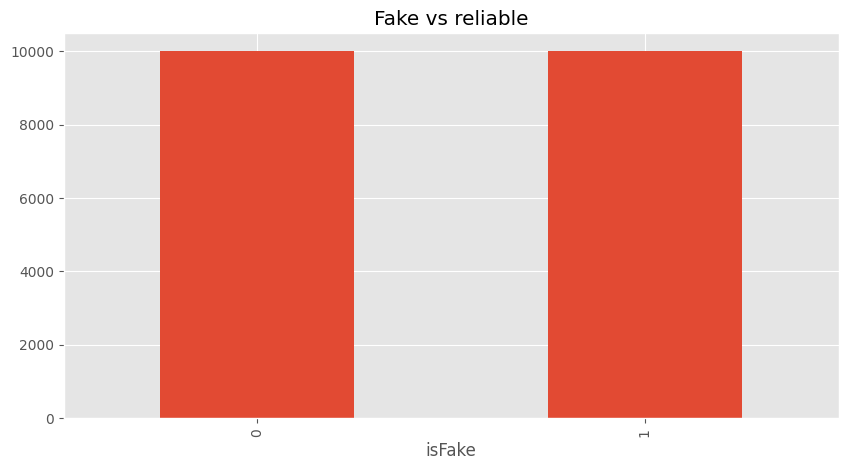

In [22]:
ax = df_adjusted['isfake'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Fake vs reliable',
          figsize=(10, 5))
ax.set_xlabel('isFake')
plt.show()

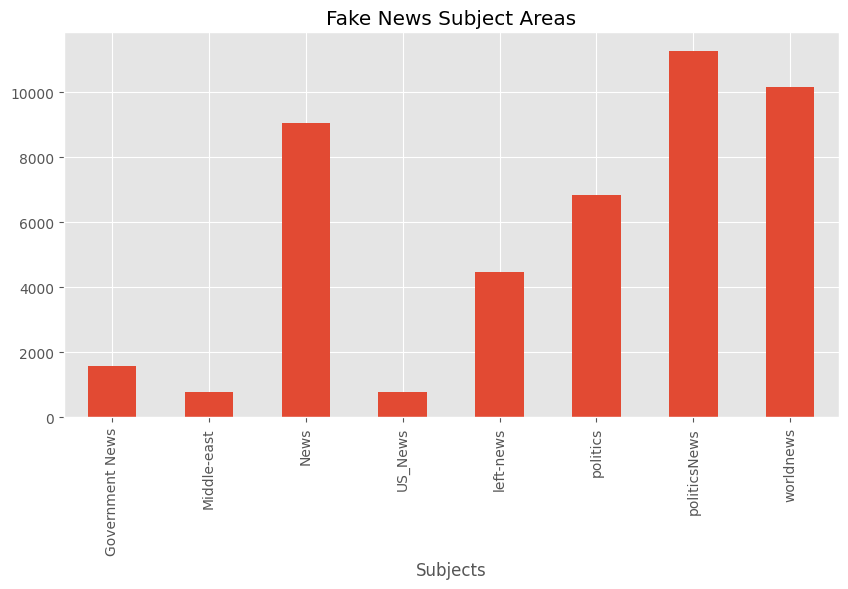

In [23]:
ax = df['subject'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Fake News Subject Areas',
          figsize=(10, 5))
ax.set_xlabel('Subjects')
plt.show()

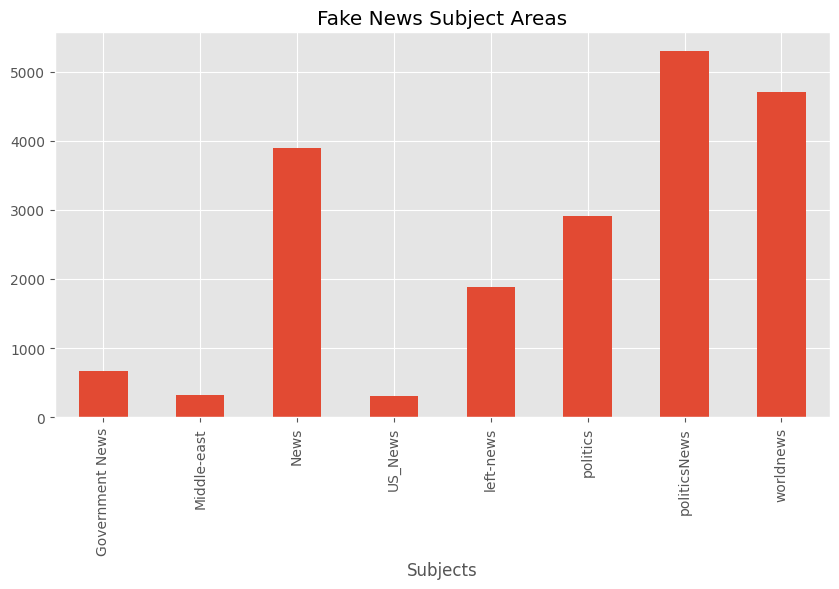

In [24]:
ax = df_adjusted['subject'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Fake News Subject Areas',
          figsize=(10, 5))
ax.set_xlabel('Subjects')
plt.show()

In [25]:
df_adjusted['original'] = df_adjusted['title'] + ' ' + df_adjusted['text']
df_adjusted.head()

title  \
10650   Vicente Fox Brilliantly Trolls Trump’s Disast...   
2041   U.S. and EU warn China on need to respect Sout...   
8668   UK Supreme Court hears attempt to change North...   
1114   Guatemalan president survives congressional vo...   
13902  Mueller Team Uniform? ‘Democratic Donkey Jerse...   

                                                    text       subject  \
10650  Former Mexican President Vicente Fox has never...          News   
2041   WASHINGTON (Reuters) - The United States and t...  politicsNews   
8668   LONDON (Reuters) - An attempt to change the la...     worldnews   
1114   GUATEMALA CITY (Reuters) - Guatemala s Congres...     worldnews   
13902  Deputy Attorney General Rod Rosenstein appeare...   Middle-east   

                      date  isfake  \
10650         May 17, 2017       1   
2041    February 18, 2016        0   
8668     October 24, 2017        0   
1114   September 12, 2017        0   
13902    December 13, 2017       1   

                                                original  
10650   Vicente Fox Brilliantly Trolls Trump’s Disast...  
2041   U.S. and EU warn China on need to respect Sout...  
8668   UK Supreme Court hears attempt to change North...  
1114   Guatemalan president survives congressional vo...  
13902  Mueller Team Uniform? ‘Democratic Donkey Jerse...

In [26]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [27]:
from gensim.parsing.preprocessing import STOPWORDS, remove_stopword_tokens
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result


In [28]:
# Apply the function to the dataframe
df_adjusted['clean'] = df_adjusted['original'].apply(preprocess)

In [29]:
print(df_adjusted['clean'][0])

['europe', 'rights', 'watchdog', 'says', 'turkey', 'emergency', 'laws', 'brussels', 'reuters', 'leading', 'european', 'rights', 'watchdog', 'called', 'turkey', 'friday', 'ease', 'post', 'coup', 'state', 'emergency', 'laws', 'seen', 'thousands', 'arrested', 'restore', 'power', 'regional', 'authorities', 'president', 'tayyip', 'erdogan', 'overseen', 'mass', 'purge', 'armed', 'forces', 'judiciary', 'crackdown', 'critics', 'including', 'academics', 'journalists', 'failed', 'military', 'coup', 'july', 'year', 'advisory', 'body', 'council', 'europe', 'turkey', 'member', 'acknowledged', 'report', 'need', 'certain', 'extraordinary', 'steps', 'taken', 'turkish', 'authorities', 'face', 'dangerous', 'armed', 'conspiracy', 'turkish', 'authorities', 'interpreted', 'extraordinary', 'powers', 'extensively', 'said', 'experts', 'known', 'venice', 'commission', 'opinion', 'legal', 'force', 'urged', 'ankara', 'lift', 'laws', 'allowing', 'pick', 'mayors', 'deputy', 'mayors', 'members', 'local', 'councils'

In [30]:
list_of_words = []
for i in df_adjusted.clean:
    for j in i:
        list_of_words.append(j)

In [31]:
list_of_words

['vicente',
 'brilliantly',
 'trolls',
 'trump',
 'disastrous',
 'week',
 'glorious',
 'mexican',
 'president',
 'vicente',
 'donald',
 'trump',
 'presidential',
 'campaign',
 'routinely',
 'went',
 'trump',
 'disparaging',
 'remarks',
 'mexican',
 'immigrants',
 'infamously',
 'said',
 'mexico',
 'king',
 'wall',
 'president',
 'trump',
 'favorite',
 'platform',
 'twitter',
 'troll',
 'absolute',
 'incompetence',
 'coming',
 'white',
 'house',
 'trump',
 'like',
 'paid',
 'attention',
 'donald',
 'trump',
 'campaign',
 'ascent',
 'white',
 'house',
 'knows',
 'presidential',
 'running',
 'nation',
 'donald',
 'trump',
 'insatiable',
 'insecurity',
 'constant',
 'quest',
 'money',
 'power',
 'lifelong',
 'pattern',
 'running',
 'president',
 'thing',
 'left',
 'president',
 'tweeted',
 'realdonaldtrump',
 'weepy',
 'wanted',
 'center',
 'attention',
 'kind',
 'wanted',
 'right',
 'vicente',
 'quesada',
 'vicentefoxque',
 'trump',
 'thought',
 'president',
 'govern',
 'likely',
 'though

In [32]:
len(list_of_words)
total_words = len(list(set(list_of_words)))
total_words

77343

In [33]:
df_adjusted['clean_joined'] = df_adjusted['clean'].apply(lambda x: " ".join(x))
df_adjusted

title  \
10650   Vicente Fox Brilliantly Trolls Trump’s Disast...   
2041   U.S. and EU warn China on need to respect Sout...   
8668   UK Supreme Court hears attempt to change North...   
1114   Guatemalan president survives congressional vo...   
13902  Mueller Team Uniform? ‘Democratic Donkey Jerse...   
...                                                  ...   
11284   White House Defends Boehner’s ‘Lucifer’ Comme...   
11964  HILARIOUS: TRUMP EXPOSES STUPIDITY OF NBC PUPP...   
5390   Mueller seeking testimony from PR executives w...   
860    Supreme Court dismisses Hawaii's challenge to ...   
15795  WOMAN Who Wants To Become DNC Chair: “My job i...   

                                                    text       subject  \
10650  Former Mexican President Vicente Fox has never...          News   
2041   WASHINGTON (Reuters) - The United States and t...  politicsNews   
8668   LONDON (Reuters) - An attempt to change the la...     worldnews   
1114   GUATEMALA CITY (Reuters) - Guatemala s Congres...     worldnews   
13902  Deputy Attorney General Rod Rosenstein appeare...   Middle-east   
...                                                  ...           ...   
11284  Ever since former House Speaker John Boehner a...          News   
11964  Trump made sure everyone got a chance to see h...      politics   
5390   WASHINGTON (Reuters) - Special Counsel Robert ...  politicsNews   
860    WASHINGTON (Reuters) - The U.S. Supreme Court ...  politicsNews   
15795  The Democratic Party held a forum for race obs...      politics   

                      date  isfake  \
10650         May 17, 2017       1   
2041    February 18, 2016        0   
8668     October 24, 2017        0   
1114   September 12, 2017        0   
13902    December 13, 2017       1   
...                    ...     ...   
11284       April 29, 2016       1   
11964         Aug 19, 2015       1   
5390      August 25, 2017        0   
860      October 24, 2017        0   
15795         Jan 24, 2017       1   

                                                original  \
10650   Vicente Fox Brilliantly Trolls Trump’s Disast...   
2041   U.S. and EU warn China on need to respect Sout...   
8668   UK Supreme Court hears attempt to change North...   
1114   Guatemalan president survives congressional vo...   
13902  Mueller Team Uniform? ‘Democratic Donkey Jerse...   
...                                                  ...   
11284   White House Defends Boehner’s ‘Lucifer’ Comme...   
11964  HILARIOUS: TRUMP EXPOSES STUPIDITY OF NBC PUPP...   
5390   Mueller seeking testimony from PR executives w...   
860    Supreme Court dismisses Hawaii's challenge to ...   
15795  WOMAN Who Wants To Become DNC Chair: “My job i...   

                                                   clean  \
10650  [vicente, brilliantly, trolls, trump, disastro...   
2041   [warn, china, need, respect, south, china, rul...   
8668   [supreme, court, hears, attempt, change, north...   
1114   [guatemalan, president, survives, congressiona...   
13902  [mueller, team, uniform, democratic, donkey, j...   
...                                                  ...   
11284  [white, house, defends, boehner, lucifer, comm...   
11964  [hilarious, trump, exposes, stupidity, puppet,...   
5390   [mueller, seeking, testimony, executives, mana...   
860    [supreme, court, dismisses, hawaii, challenge,...   
15795  [woman, wants, chair, shut, white, people, pre...   

                                            clean_joined  
10650  vicente brilliantly trolls trump disastrous we...  
2041   warn china need respect south china ruling was...  
8668   supreme court hears attempt change northern ir...  
1114   guatemalan president survives congressional vo...  
13902  mueller team uniform democratic donkey jerseys...  
...                                                  ...  
11284  white house defends boehner lucifer comment cr...  
11964  hilarious trump exposes stupidity puppet repor...  
5390   muel

In [34]:
example = df_adjusted['clean_joined']
print(example)

10650    vicente brilliantly trolls trump disastrous we...
2041     warn china need respect south china ruling was...
8668     supreme court hears attempt change northern ir...
1114     guatemalan president survives congressional vo...
13902    mueller team uniform democratic donkey jerseys...
                               ...                        
11284    white house defends boehner lucifer comment cr...
11964    hilarious trump exposes stupidity puppet repor...
5390     mueller seeking testimony executives manafort ...
860      supreme court dismisses hawaii challenge trump...
15795    woman wants chair shut white people prejudiced...
Name: clean_joined, Length: 20000, dtype: object


In [35]:
# tokens = nltk.word_tokenize(example)
tokens = nltk.word_tokenize(str(example))
tokens[:10]

['10650',
 'vicente',
 'brilliantly',
 'trolls',
 'trump',
 'disastrous',
 'we',
 '...',
 '2041',
 'warn']

In [36]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('10650', 'CD'),
 ('vicente', 'NN'),
 ('brilliantly', 'RB'),
 ('trolls', 'VBZ'),
 ('trump', 'JJ'),
 ('disastrous', 'JJ'),
 ('we', 'PRP'),
 ('...', ':'),
 ('2041', 'CD'),
 ('warn', 'IN')]

In [37]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  10650/CD
  vicente/NN
  brilliantly/RB
  trolls/VBZ
  trump/JJ
  disastrous/JJ
  we/PRP
  .../:
  2041/CD
  warn/IN
  china/NNS
  need/VBP
  respect/JJ
  south/JJ
  china/NN
  ruling/NN
  was/VBD
  .../:
  8668/CD
  supreme/JJ
  court/NN
  hears/NNS
  attempt/VBP
  change/NN
  northern/JJ
  ir/NN
  .../:
  1114/CD
  guatemalan/NN
  president/NN
  survives/VBZ
  congressional/JJ
  vo/NN
  .../:
  13902/CD
  mueller/NN
  team/NN
  uniform/RB
  democratic/JJ
  donkey/NN
  jerseys/NNS
  .../:
  .../:
  11284/CD
  white/JJ
  house/NN
  defends/VBZ
  boehner/NN
  lucifer/JJ
  comment/NN
  cr/NN
  .../:
  11964/CD
  hilarious/JJ
  trump/NN
  exposes/VBZ
  stupidity/NN
  puppet/NN
  repor/NN
  .../:
  5390/CD
  mueller/NN
  seeking/VBG
  testimony/NN
  executives/NNS
  manafort/VBP
  .../:
  860/CD
  supreme/JJ
  court/NN
  dismisses/NNS
  hawaii/VBP
  challenge/NN
  trump/NN
  .../:
  15795/CD
  woman/NN
  wants/VBZ
  chair/JJ
  shut/JJ
  white/JJ
  people/NNS
  prejudiced/VBD
  .../:
  

In [38]:
sia = SentimentIntensityAnalyzer()

In [39]:
sia.polarity_scores('As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non')

{'neg': 0.101, 'neu': 0.84, 'pos': 0.059, 'compound': -0.7269}

In [40]:
sia.polarity_scores(str(example))

{'neg': 0.098, 'neu': 0.717, 'pos': 0.185, 'compound': 0.8625}

In [41]:
df_adjusted['id'] = df_adjusted.index + 1

In [44]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df_adjusted.iterrows(), total=len(df_adjusted)):
    text = row['text']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [45]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df_adjusted, how='left')

In [46]:
vaders.tail()

id    neg    neu    pos  compound  \
19995  11285  0.078  0.759  0.162    0.9830   
19996  11965  0.000  0.863  0.137    0.5106   
19997   5391  0.036  0.915  0.049    0.4019   
19998    861  0.196  0.705  0.099   -0.9938   
19999  15796  0.055  0.799  0.146    0.9919   

                                                   title  \
19995   White House Defends Boehner’s ‘Lucifer’ Comme...   
19996  HILARIOUS: TRUMP EXPOSES STUPIDITY OF NBC PUPP...   
19997  Mueller seeking testimony from PR executives w...   
19998  Supreme Court dismisses Hawaii's challenge to ...   
19999  WOMAN Who Wants To Become DNC Chair: “My job i...   

                                                    text       subject  \
19995  Ever since former House Speaker John Boehner a...          News   
19996  Trump made sure everyone got a chance to see h...      politics   
19997  WASHINGTON (Reuters) - Special Counsel Robert ...  politicsNews   
19998  WASHINGTON (Reuters) - The U.S. Supreme Court ...  politicsNews   
19999  The Democratic Party held a forum for race obs...      politics   

                    date  isfake  \
19995     April 29, 2016       1   
19996       Aug 19, 2015       1   
19997   August 25, 2017        0   
19998  October 24, 2017        0   
19999       Jan 24, 2017       1   

                                                original  \
19995   White House Defends Boehner’s ‘Lucifer’ Comme...   
19996  HILARIOUS: TRUMP EXPOSES STUPIDITY OF NBC PUPP...   
19997  Mueller seeking testimony from PR executives w...   
19998  Supreme Court dismisses Hawaii's challenge to ...   
19999  WOMAN Who Wants To Become DNC Chair: “My job i...   

                                                   clean  \
19995  [white, house, defends, boehner, lucifer, comm...   
19996  [hilarious, trump, exposes, stupidity, puppet,...   
19997  [mueller, seeking, testimony, executives, mana...   
19998  [supreme, court, dismisses, hawaii, challenge,...   
19999  [woman, wants, chair, shut, white, people, pre...   

                                            clean_joined  
19995  white house defends boehner lucifer comment cr...  
19996  hilarious trump exposes stupidity puppet repor...  
19997  mueller seeking testimony executives manafort ...  
19998  supreme court dismisses hawaii challenge trump...  
19999  woman wants chair shut white people prejudiced...

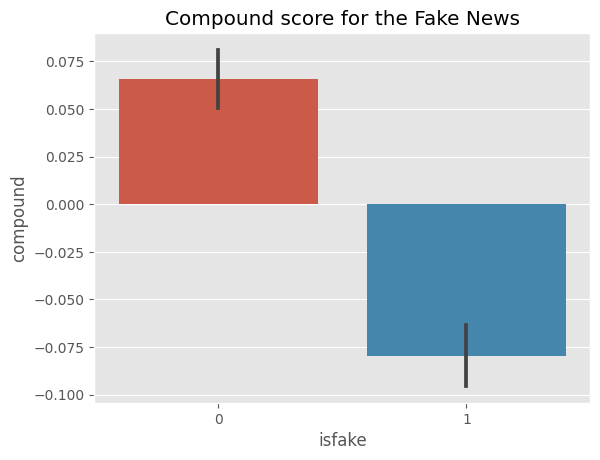

In [47]:
ax = sns.barplot(data=vaders, x='isfake', y='compound')
ax.set_title('Compound score for the Fake News')
plt.show()

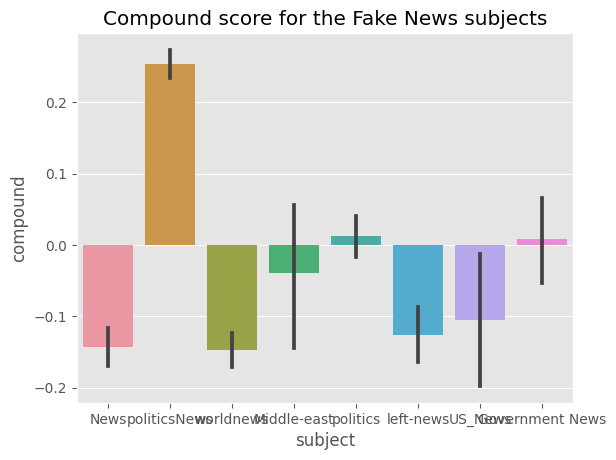

In [48]:
ax = sns.barplot(data=vaders, x='subject', y='compound')
ax.set_title('Compound score for the Fake News subjects')
plt.show()

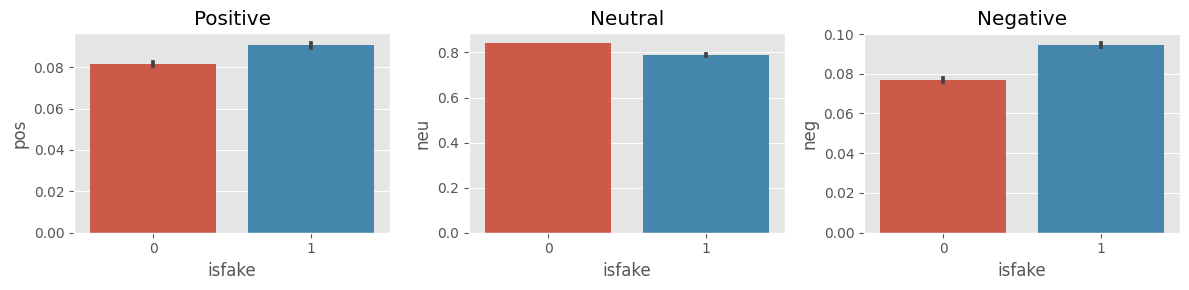

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='isfake', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='isfake', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='isfake', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [50]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [51]:
# VADER results on example
print(example)
sia.polarity_scores(str(example))

10650    vicente brilliantly trolls trump disastrous we...
2041     warn china need respect south china ruling was...
8668     supreme court hears attempt change northern ir...
1114     guatemalan president survives congressional vo...
13902    mueller team uniform democratic donkey jerseys...
                               ...                        
11284    white house defends boehner lucifer comment cr...
11964    hilarious trump exposes stupidity puppet repor...
5390     mueller seeking testimony executives manafort ...
860      supreme court dismisses hawaii challenge trump...
15795    woman wants chair shut white people prejudiced...
Name: clean_joined, Length: 20000, dtype: object


{'neg': 0.098, 'neu': 0.717, 'pos': 0.185, 'compound': 0.8625}

In [52]:
# Run for Roberta Model
encoded_text = tokenizer(str(example), return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.5237015, 'roberta_neu': 0.44331527, 'roberta_pos': 0.03298325}


In [53]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [54]:
# #not this
# res = {}
# for i, row in tqdm(df.iterrows(), total=len(df)):
#     try:
#         text = row['text']
#         myid = row['id']
#         vader_result = sia.polarity_scores(text)
#         vader_result_rename = {}
#         for key, value in vader_result.items():
#             vader_result_rename[f"vader_{key}"] = value
#         roberta_result = polarity_scores_roberta(text)
#         both = {**vader_result_rename, **roberta_result}
#         res[myid] = both
#     except RuntimeError:
#         print(f'Broke for id {myid}')

# # First 500 texts
# # res = {}
# # num_rows_to_process = 500

# # for i, row in tqdm(df.head(num_rows_to_process).iterrows(), total=num_rows_to_process):
# #     try:
# #         text = row['text']
# #         myid = row['id']
# #         vader_result = sia.polarity_scores(text)
# #         vader_result_rename = {}
# #         for key, value in vader_result.items():
# #             vader_result_rename[f"vader_{key}"] = value
# #         roberta_result = polarity_scores_roberta(text)
# #         both = {**vader_result_rename, **roberta_result}
# #         res[myid] = both
# #     except RuntimeError:
# #         print(f'Broke for id {myid}')


In [56]:
# res = {}

# for i, row in tqdm(df.iterrows(), total=len(df)):
#     try:
#         text = row['text']
#         myid = row['id']

#         # Check for empty or very short texts
#         if not text or len(text) < 3:
#             print(f'Skipping empty or very short text for id {myid}')
#             continue

#         vader_result = sia.polarity_scores(text)
#         vader_result_rename = {}
#         for key, value in vader_result.items():
#             vader_result_rename[f"vader_{key}"] = value

#         roberta_result = polarity_scores_roberta(text)

#         both = {**vader_result_rename, **roberta_result}
#         res[myid] = both

#     except RuntimeError as e:
#         print(f'Broke for id {myid}: {e}')
#     except IndexError as e:
#         print(f'Index error for id {myid}: {e}')

res = {}
batch_size = 100

for batch_start in tqdm(range(0, len(df_adjusted), batch_size)):
    batch_df = df_adjusted.iloc[batch_start:batch_start + batch_size]

    for i, row in batch_df.iterrows():
        try:
            text = row['text']
            myid = row['id']

            if not text or len(text) < 3:
                print(f'Skipping empty or very short text for id {myid}')
                continue

            vader_result = sia.polarity_scores(text)
            vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}

            roberta_result = polarity_scores_roberta(text)

            both = {**vader_result_rename, **roberta_result}
            res[myid] = both

        except RuntimeError as e:
            print(f'Broke for id {myid}: {e}')
        except IndexError as e:
            print(f'Index error for id {myid}: {e}')



  0%|          | 0/200 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Broke for id 14148: The expanded size of the tensor (1676) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1676].  Tensor sizes: [1, 514]
Broke for id 2367: The expanded size of the tensor (1063) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1063].  Tensor sizes: [1, 514]
Broke for id 16675: The expanded size of the tensor (705) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 705].  Tensor sizes: [1, 514]
Broke for id 16460: The expanded size of the tensor (830) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 830].  Tensor sizes: [1, 514]
Broke for id 11195: The expanded size of the tensor (1676) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1676].  Tensor sizes: [1, 514]
Broke for id 4787: The expanded size of the tensor (549) must match the existing siz

In [58]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df_adjusted, how='left')

In [59]:
results_df.columns

Index(['id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'title', 'text', 'subject',
       'date', 'isfake', 'original', 'clean', 'clean_joined'],
      dtype='object')

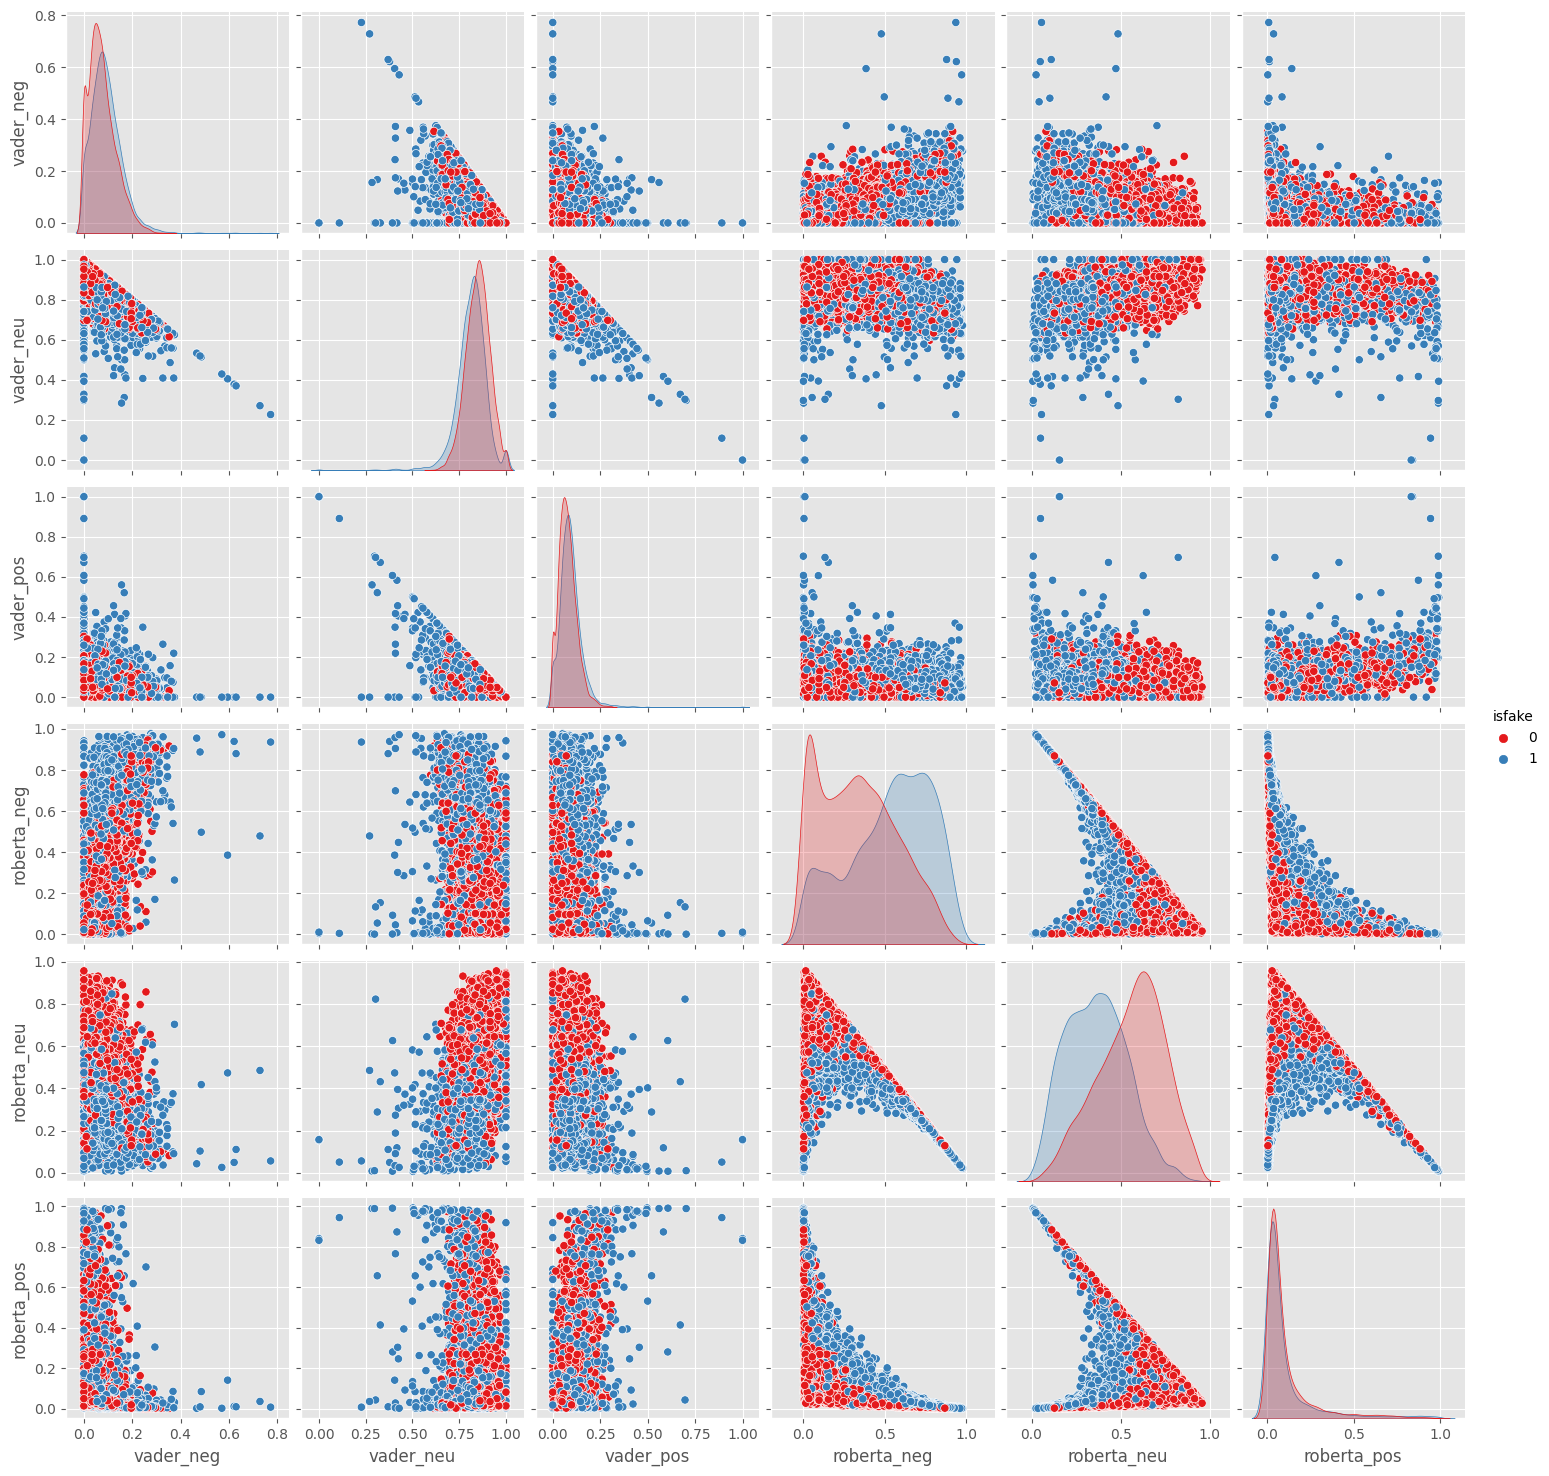

In [60]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos',],
            hue='isfake',
            palette='Set1')
plt.show()

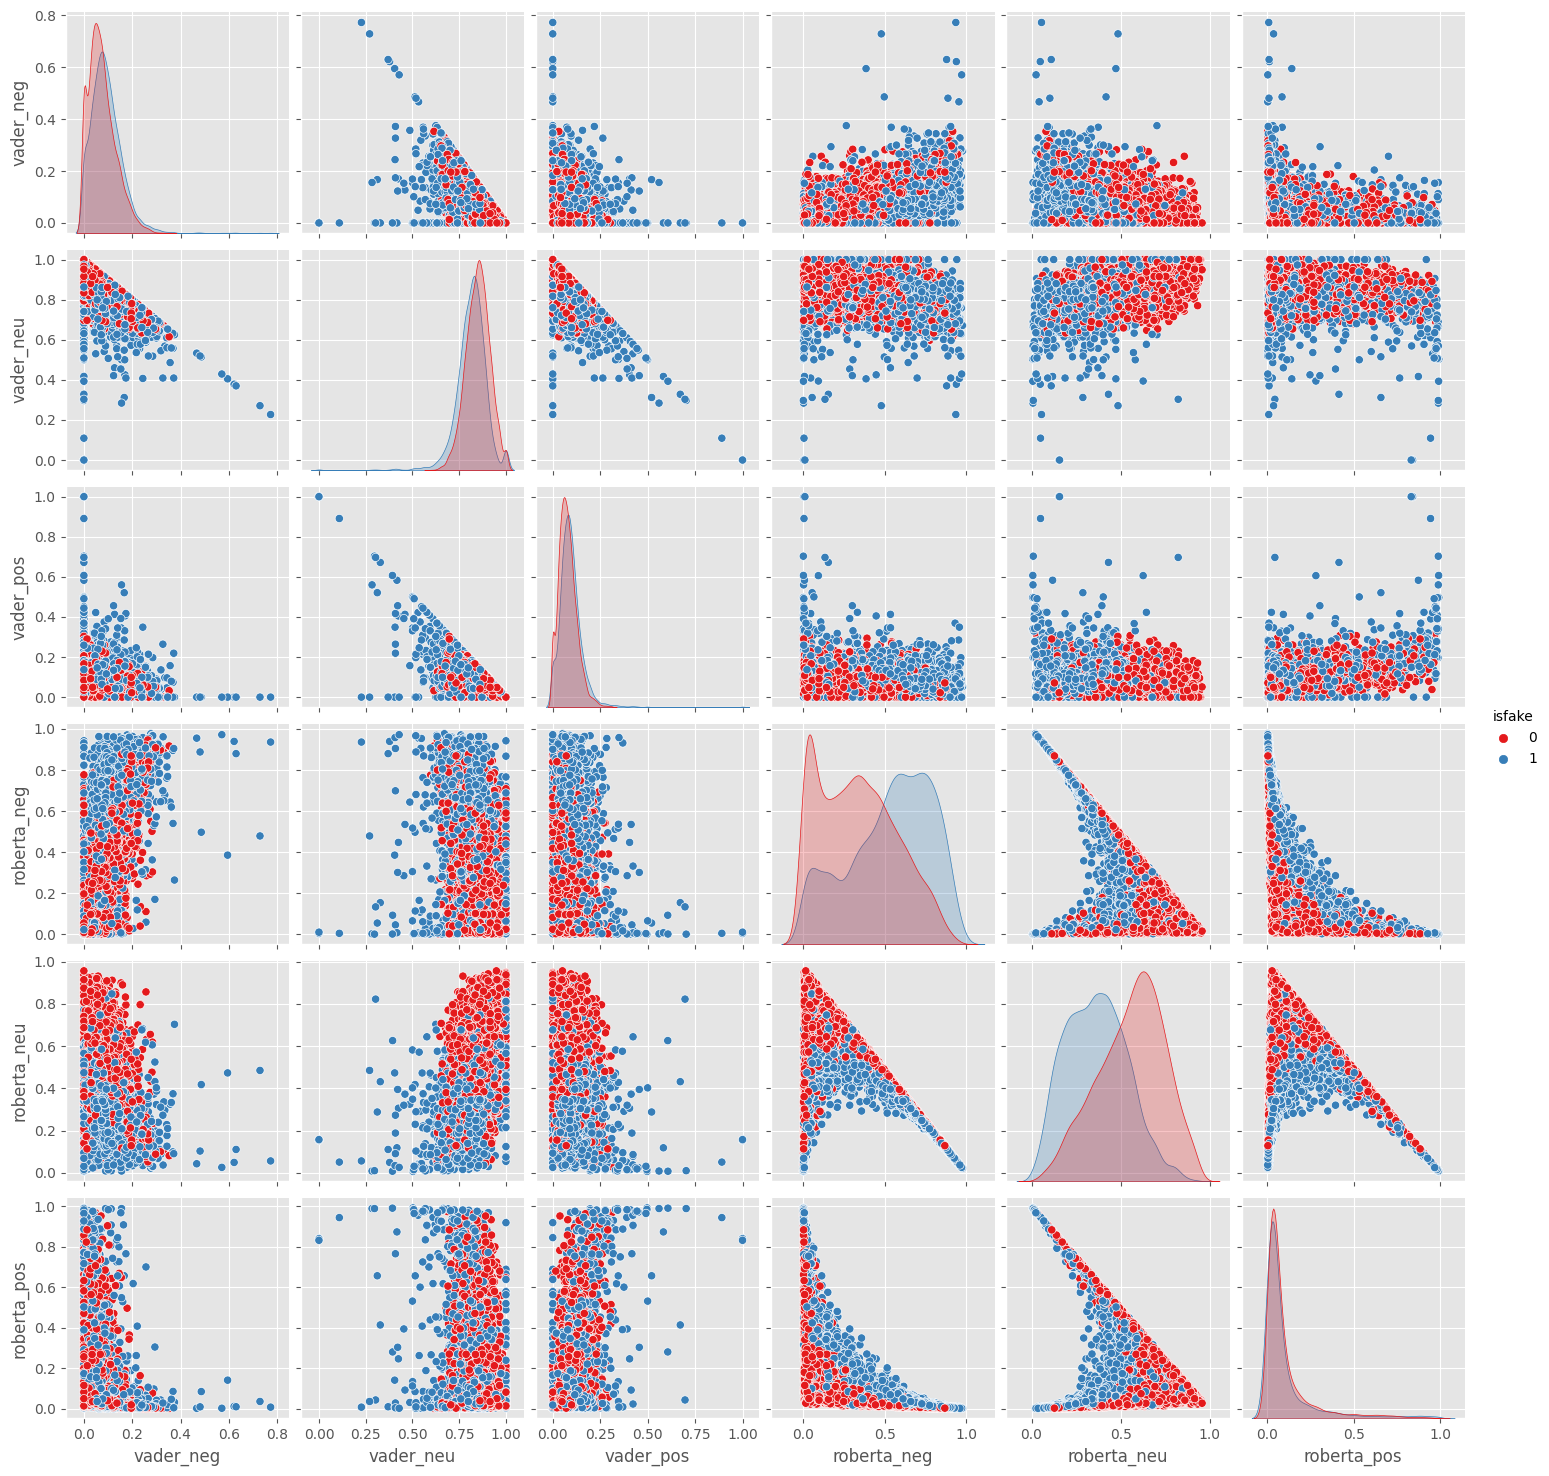

In [61]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos',],
            hue='isfake',
            palette='Set1')
plt.show()

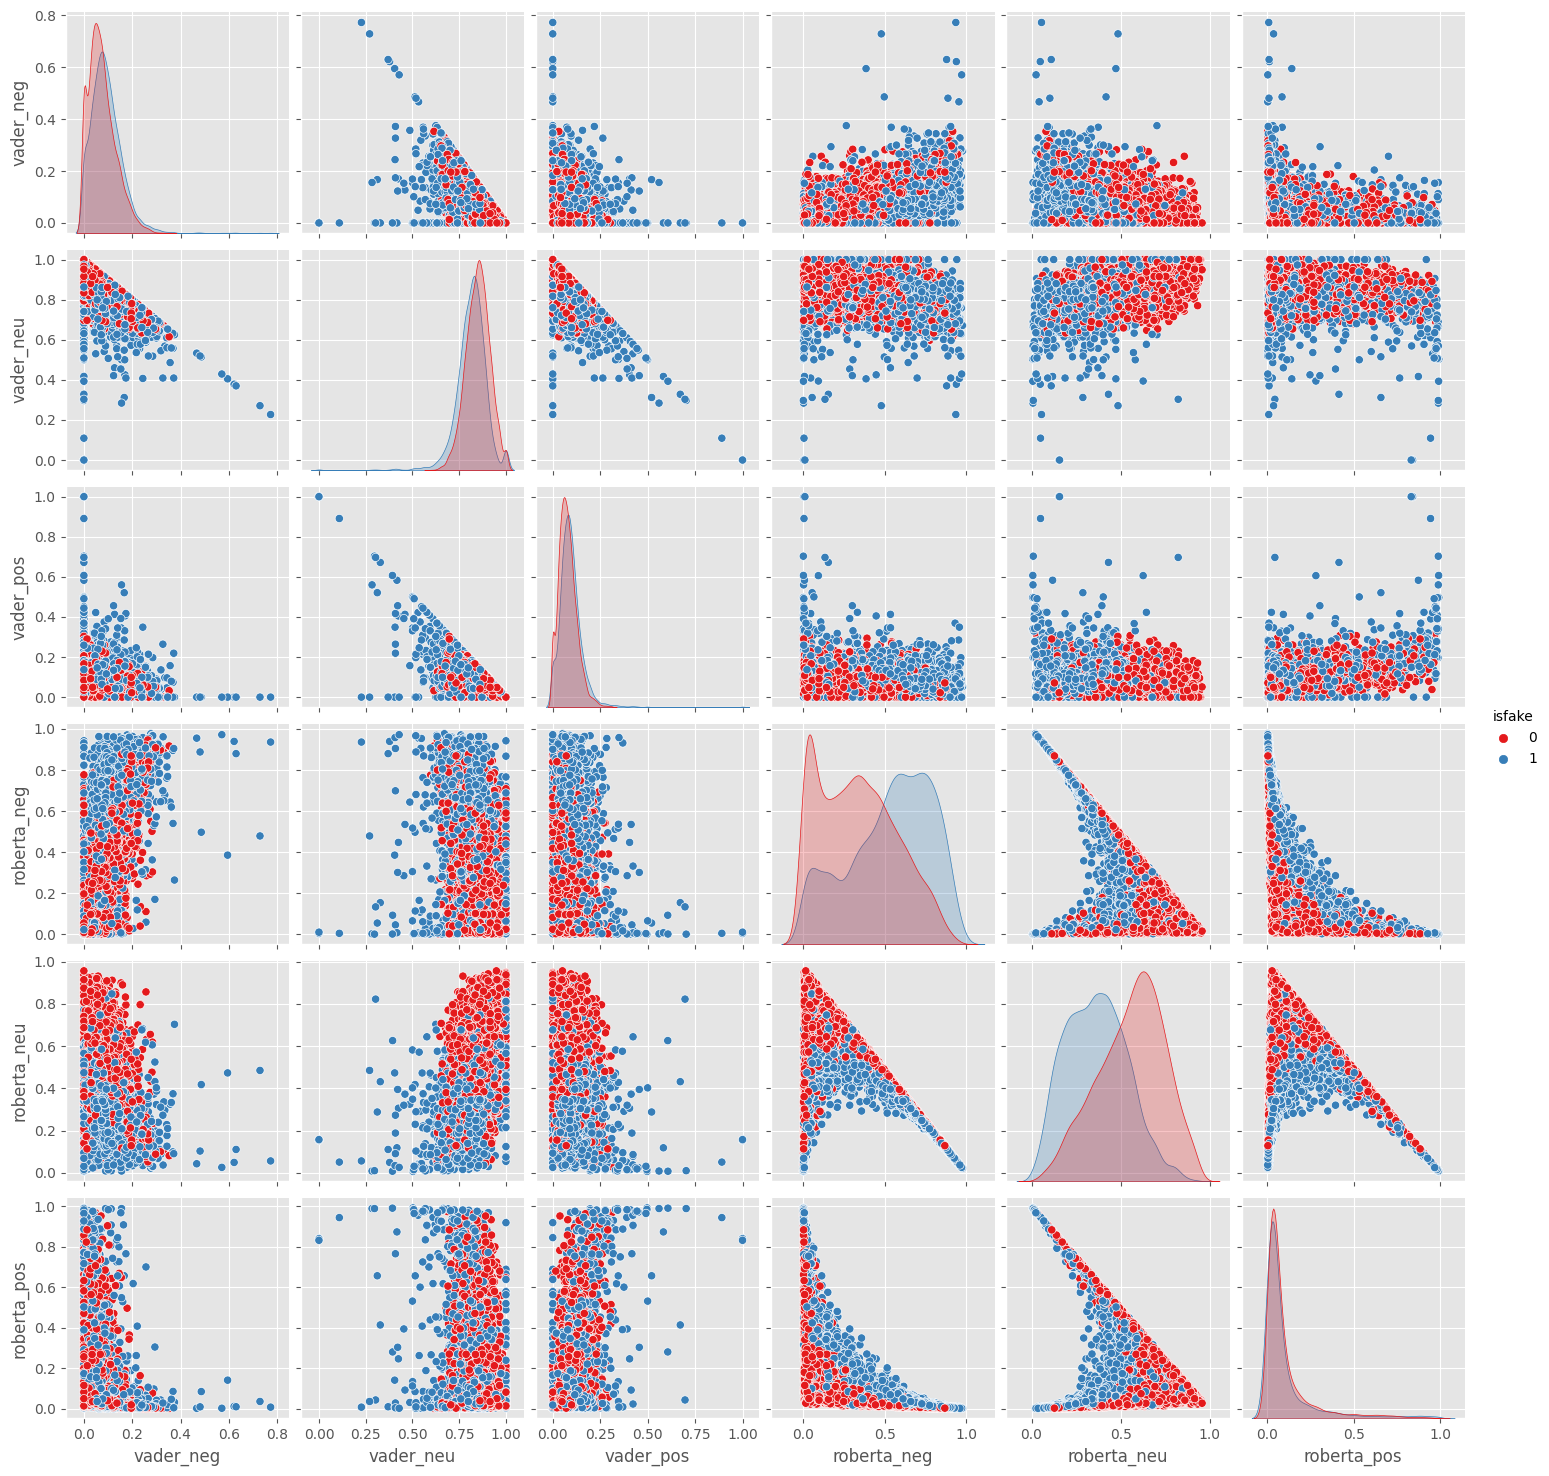

In [62]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos',],
            hue='isfake',
            palette='Set1')
plt.show()

In [ ]:
results_df.query('isfake == 1') \
    .sort_values('roberta_fake', ascending=False)['text'].values[0]

In [ ]:
results_df.query('isfake == 0') \
    .sort_values('roberta_fake', ascending=False)['text'].values[0]

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_adjusted[df_adjusted.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [63]:
maxlen = -1
for doc in df_adjusted.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


In [ ]:
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis on 'original' column and store the compound score in 'vader_score'
df['vader_score'] = df['clean_joined'].apply(lambda x: sid.polarity_scores(x)['compound'])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


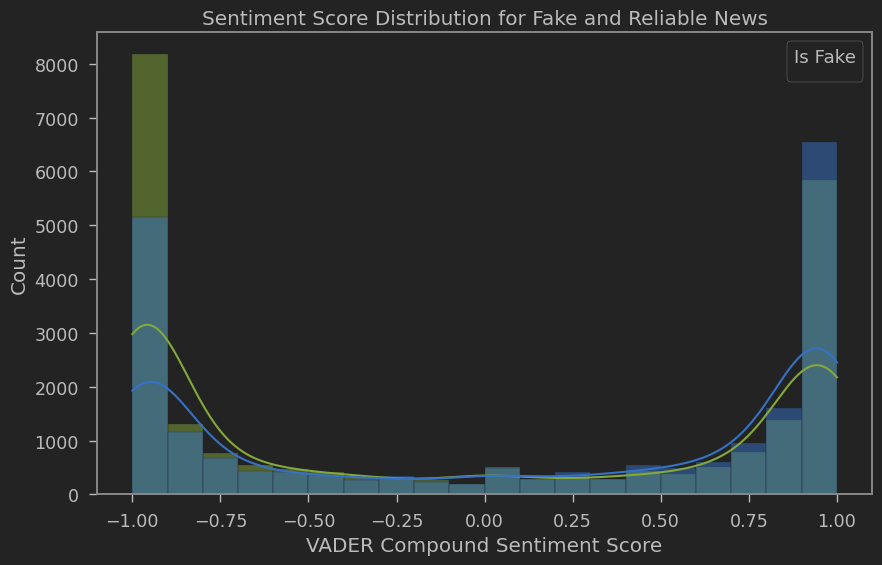

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='vader_score', hue='isfake', kde=True, bins=20)
plt.title('Sentiment Score Distribution for Fake and Reliable News')
plt.xlabel('VADER Compound Sentiment Score')
plt.legend(title='Is Fake')
plt.show()

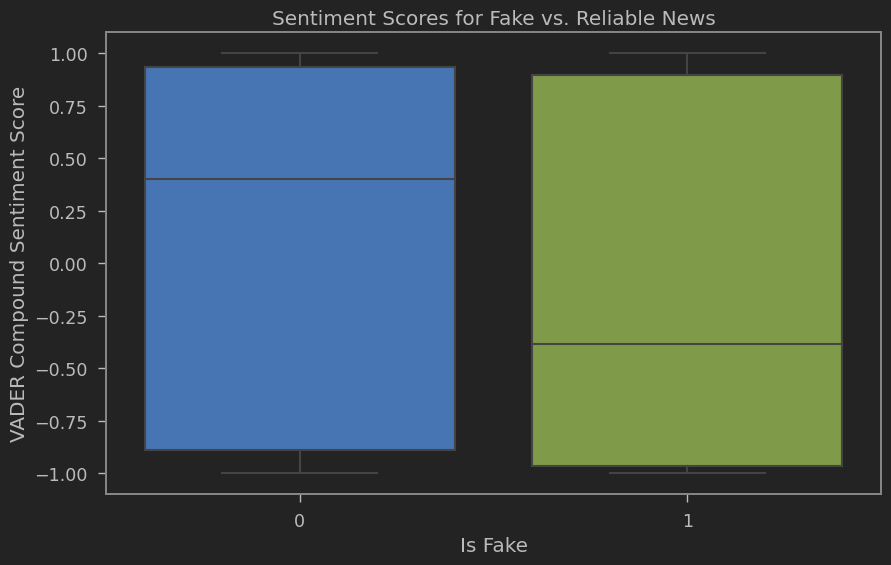

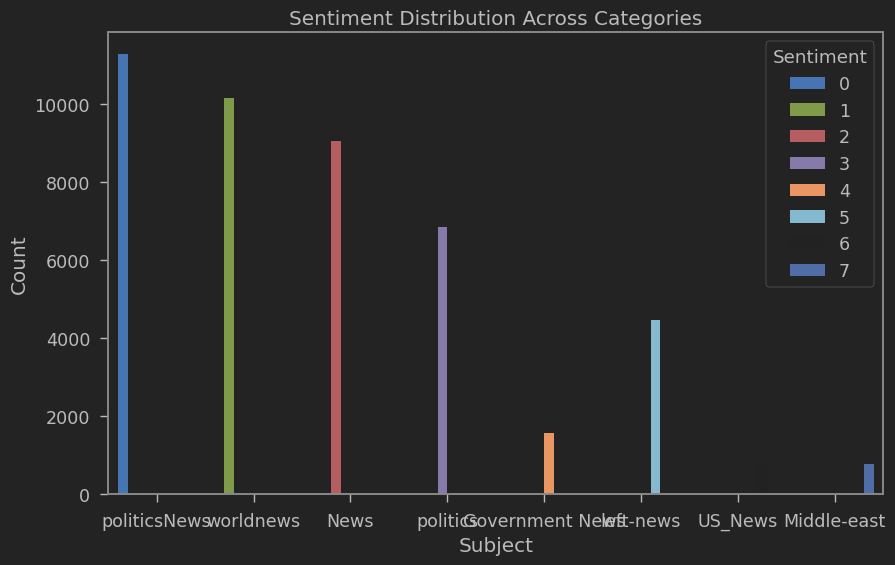

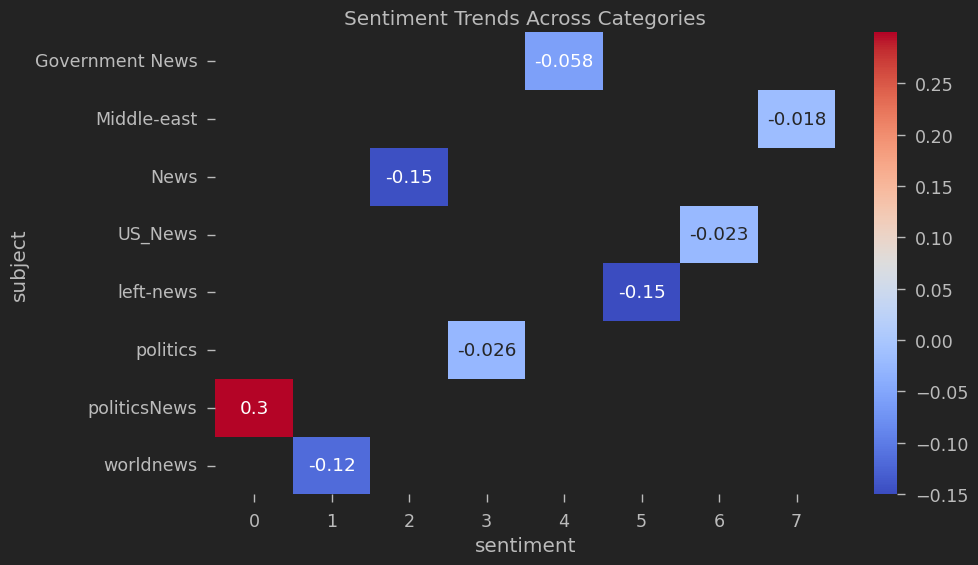

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot of sentiment scores for fake and reliable news
plt.figure(figsize=(10, 6))
sns.boxplot(x='isfake', y='vader_score', data=df)
plt.title('Sentiment Scores for Fake vs. Reliable News')
plt.xlabel('Is Fake')
plt.ylabel('VADER Compound Sentiment Score')
plt.show()

# Bar plot showing counts of positive, negative, and neutral sentiments for each category
plt.figure(figsize=(10, 6))
sns.countplot(x='subject', hue='sentiment', data=df)
plt.title('Sentiment Distribution Across Categories')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# Scatter plot of sentiment scores vs. text length
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='text_length', y='vader_score', data=df)
# plt.title('Sentiment Score vs. Text Length')
# plt.xlabel('Text Length')
# plt.ylabel('VADER Compound Sentiment Score')
# plt.show()

# Heatmap for sentiment trends across categories
heatmap_data = df.pivot_table(index='subject', columns='sentiment', values='vader_score', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True)
plt.title('Sentiment Trends Across Categories')
plt.show()


In [ ]:
# split data into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)
from nltk import word_tokenize


In [ ]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [ ]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post')
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [    1  1093  1609  2850  5308    32   147  7661    25     9    10     1
 22567   580    34   624   469    15     8  2452    94   258    32  1093
  3459  1609  2850  5328  8296   947    32  2935   441     1   319  4721
    19  1233    13    47]
The padded encoding for document 2  is :  [  618    31   353   392    48  1167  9250    46   149  3690     9   618
    31   353   392    48  1167   786  9250   651   126   325    17   273
     2    85  7575  5743   120  1007   283  1094  2182  1302  2278   871
 49711   618  3382   426]


In [ ]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         13914112  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,210,305
Trainable params: 14,210,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
total_words

108704

In [ ]:
y_train = np.asarray(y_train)
# train the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 [==============================] - 274s 534ms/step - loss: 0.0444 - acc: 0.9834 - val_loss: 0.0075 - val_acc: 0.9978
Epoch 2/2
506/506 [==============================] - 275s 545ms/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0045 - val_acc: 0.9983


In [ ]:
# make detection
detect = model.predict(padded_test)
# if the predicted value is >0.5 it is real else it is fake
detection = []
for i in range(len(detect)):
    if detect[i].item() > 0.5:
        detection.append(1)
    else:
        detection.append(0)
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), detection)

print("Model Accuracy : ", accuracy)

281/281 [==============================] - 16s 55ms/step
Model Accuracy :  0.9985523385300669


In [ ]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), detection)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

In [ ]:
# category dict
category = { 0: 'Fake News', 1 : "Reliable News"}


In [ ]:
def load_model_and_tokenizer():
    # Load the tokenizer and total_words from the previous code
    total_words = ...

    tokenizer = Tokenizer(num_words=total_words)
    model = Sequential()
    model.add(Embedding(total_words, output_dim=128))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # Load the weights for the trained model
    model.load_weights("path_to_model_weights")  # Replace "path_to_model_weights" with the actual path of the model weights file

    return tokenizer, model

In [ ]:
# Function to preprocess and classify the news article
def classify_news_input(input_text, tokenizer, model):
    processed_text = preprocess(input_text)
    sequences = tokenizer.texts_to_sequences([processed_text])
    padded_sequences = pad_sequences(sequences, maxlen=40, padding='post', truncating='post')
    prediction = model.predict(padded_sequences)
    return "Reliable News" if prediction.item() > 0.5 else "Fake News"

# Call the function to load the tokenizer and model
tokenizer, model = load_model_and_tokenizer()

# Test with user input
user_input = input("Enter a news article for classification: ")
result = classify_news_input(user_input, tokenizer, model)
print("The news article is classified as:", result)

TypeError: ignored

-------------------------------------

In [ ]:
def classify_news(input_text, tokenizer, model):
    # Preprocess the input text
    processed_text = preprocess(input_text)

    # Tokenize and pad the processed text
    sequences = tokenizer.texts_to_sequences([processed_text])
    padded_sequences = pad_sequences(sequences, maxlen=40, padding='post', truncating='post')

    # Make prediction using the loaded model
    prediction = model.predict(padded_sequences)

    # If the predicted value is greater than 0.5, it is classified as "Reliable News",
    # otherwise, it is classified as "Fake News"
    if prediction.item() > 0.5:
        return "Reliable News"
    else:
        return "Fake News"


# Call the function to load the tokenizer and model
tokenizer, model = load_model_and_tokenizer()

TypeError: ignored

In [ ]:


# Now, let's say you have a fake news and a reliable news for testing purposes
fake_news = "This is a fake news article with misleading information."
reliable_news = "This is a reliable news article with accurate information."

# Classify the fake news and reliable news using the classify_news function
result_fake = classify_news(fake_news, tokenizer, model)
result_reliable = classify_news(reliable_news, tokenizer, model)

print("Fake News:", result_fake)
print("Reliable News:", result_reliable)


NameError: ignored

In [ ]:
# Your existing code...

# Now, let's say you have a fake news and a reliable news for testing purposes
fake_news = "This is a reliable news article with misleading information."
reliable_news = "This is a reliable news article with accurate information."

# Preprocess the news articles
processed_fake_news = preprocess(fake_news)
processed_reliable_news = preprocess(reliable_news)

# Tokenize and pad the news articles
fake_sequences = tokenizer.texts_to_sequences([processed_fake_news])
reliable_sequences = tokenizer.texts_to_sequences([processed_reliable_news])

padded_fake_sequences = pad_sequences(fake_sequences, maxlen=40, padding='post', truncating='post')
padded_reliable_sequences = pad_sequences(reliable_sequences, maxlen=40, padding='post', truncating='post')

# Make predictions using the model
prediction_fake = model.predict(padded_fake_sequences)
prediction_reliable = model.predict(padded_reliable_sequences)

# If the predicted value is greater than 0.5, it is classified as "Reliable News",
# otherwise, it is classified as "Fake News"
result_fake = "Reliable News" if prediction_fake.item() > 0.5 else "Fake News"
result_reliable = "Reliable News" if prediction_reliable.item() > 0.5 else "Fake News"

print("Fake News:", result_fake)
print("Reliable News:", result_reliable)


1/1 [==============================] - 0s 26ms/step
Fake News: Fake News
Reliable News: Fake News


In [ ]:
# Your existing code...

# Now, let's say you have a fake news and a reliable news for testing purposes
fake_news = "House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys  don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the former aide set up meetings with world leaders for Trump, but team Trump ran with him being merely a coffee boy.In May 2016, Papadopoulos revealed to Australian diplomat Alexander Downer that Russian officials were shopping around possible dirt on then-Democratic presidential nominee Hillary Clinton. Exactly how much Mr. Papadopoulos said that night at the Kensington Wine Rooms with the Australian, Alexander Downer, is unclear,  the report states.  But two months later, when leaked Democratic emails began appearing online, Australian officials passed the information about Mr. Papadopoulos to their American counterparts, according to four current and former American and foreign officials with direct knowledge of the Australians  role. Papadopoulos pleaded guilty to lying to the F.B.I. and is now a cooperating witness with Special Counsel Robert Mueller s team.This isn t a presidency. It s a badly scripted reality TV show.Photo by Win McNamee/Getty Images."
reliable_news = " U.S. President Donald Trump called on the Republican Congress to pass a short-term government spending bill later on Thursday to avoid a shutdown when current funding expires at midnight on Friday. Republicans in the House of Representatives have unveiled a stopgap spending bill that would allow the government to stay open at current funding levels. â€œPass the C.R. (continuing resolution) TODAY and keep our Government OPEN!â€ Trump wrote in a post on Twitter."

# Preprocess the news articles
processed_fake_news = preprocess(fake_news)
processed_reliable_news = preprocess(reliable_news)

# Tokenize and pad the news articles
fake_sequences = tokenizer.texts_to_sequences([processed_fake_news])
reliable_sequences = tokenizer.texts_to_sequences([processed_reliable_news])

padded_fake_sequences = pad_sequences(fake_sequences, maxlen=40, padding='post', truncating='post')
padded_reliable_sequences = pad_sequences(reliable_sequences, maxlen=40, padding='post', truncating='post')

# Make predictions using the model
prediction_fake = model.predict(padded_fake_sequences)
prediction_reliable = model.predict(padded_reliable_sequences)

# If the predicted value is greater than 0.5, it is classified as "Reliable News",
# otherwise, it is classified as "Fake News"
result_fake = "Reliable News" if prediction_fake.item() > 0.5 else "Fake News"
result_reliable = "Reliable News" if prediction_reliable.item() > 0.5 else "Fake News"

print("Fake News:", result_fake)
print("Reliable News:", result_reliable)


1/1 [==============================] - 0s 42ms/step
Fake News: Fake News
Reliable News: Reliable News


In [64]:
df_adjusted

title  \
10650   Vicente Fox Brilliantly Trolls Trump’s Disast...   
2041   U.S. and EU warn China on need to respect Sout...   
8668   UK Supreme Court hears attempt to change North...   
1114   Guatemalan president survives congressional vo...   
13902  Mueller Team Uniform? ‘Democratic Donkey Jerse...   
...                                                  ...   
11284   White House Defends Boehner’s ‘Lucifer’ Comme...   
11964  HILARIOUS: TRUMP EXPOSES STUPIDITY OF NBC PUPP...   
5390   Mueller seeking testimony from PR executives w...   
860    Supreme Court dismisses Hawaii's challenge to ...   
15795  WOMAN Who Wants To Become DNC Chair: “My job i...   

                                                    text       subject  \
10650  Former Mexican President Vicente Fox has never...          News   
2041   WASHINGTON (Reuters) - The United States and t...  politicsNews   
8668   LONDON (Reuters) - An attempt to change the la...     worldnews   
1114   GUATEMALA CITY (Reuters) - Guatemala s Congres...     worldnews   
13902  Deputy Attorney General Rod Rosenstein appeare...   Middle-east   
...                                                  ...           ...   
11284  Ever since former House Speaker John Boehner a...          News   
11964  Trump made sure everyone got a chance to see h...      politics   
5390   WASHINGTON (Reuters) - Special Counsel Robert ...  politicsNews   
860    WASHINGTON (Reuters) - The U.S. Supreme Court ...  politicsNews   
15795  The Democratic Party held a forum for race obs...      politics   

                      date  isfake  \
10650         May 17, 2017       1   
2041    February 18, 2016        0   
8668     October 24, 2017        0   
1114   September 12, 2017        0   
13902    December 13, 2017       1   
...                    ...     ...   
11284       April 29, 2016       1   
11964         Aug 19, 2015       1   
5390      August 25, 2017        0   
860      October 24, 2017        0   
15795         Jan 24, 2017       1   

                                                original  \
10650   Vicente Fox Brilliantly Trolls Trump’s Disast...   
2041   U.S. and EU warn China on need to respect Sout...   
8668   UK Supreme Court hears attempt to change North...   
1114   Guatemalan president survives congressional vo...   
13902  Mueller Team Uniform? ‘Democratic Donkey Jerse...   
...                                                  ...   
11284   White House Defends Boehner’s ‘Lucifer’ Comme...   
11964  HILARIOUS: TRUMP EXPOSES STUPIDITY OF NBC PUPP...   
5390   Mueller seeking testimony from PR executives w...   
860    Supreme Court dismisses Hawaii's challenge to ...   
15795  WOMAN Who Wants To Become DNC Chair: “My job i...   

                                                   clean  \
10650  [vicente, brilliantly, trolls, trump, disastro...   
2041   [warn, china, need, respect, south, china, rul...   
8668   [supreme, court, hears, attempt, change, north...   
1114   [guatemalan, president, survives, congressiona...   
13902  [mueller, team, uniform, democratic, donkey, j...   
...                                                  ...   
11284  [white, house, defends, boehner, lucifer, comm...   
11964  [hilarious, trump, exposes, stupidity, puppet,...   
5390   [mueller, seeking, testimony, executives, mana...   
860    [supreme, court, dismisses, hawaii, challenge,...   
15795  [woman, wants, chair, shut, white, people, pre...   

                                            clean_joined     id  
10650  vicente brilliantly trolls trump disastrous we...  10651  
2041   warn china need respect south china ruling was...   2042  
8668   supreme court hears attempt change northern ir...   8669  
1114   guatemalan president survives congressional vo...   1115  
13902  mueller team uniform democratic donkey jerseys...  13903  
...                                                  ...    ...  
11284  white house defends boehner lucifer comment cr...  11285  
11964  hilario